In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [74]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [75]:
class DNN_3(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_3, self).__init__()
        self.layer1 = nn.Linear(input_dim,32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8, 4)
        self.output_layer = nn.Linear(4, 1)

        self.bn1=nn.BatchNorm1d(32)
        self.bn2=nn.BatchNorm1d(16)
        self.bn3=nn.BatchNorm1d(8)
        self.bn4=nn.BatchNorm1d(4)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn4(self.layer4(x)))
    

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [76]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

Optunaの設定

In [77]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   

    # モデル定義
    model = DNN_3(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2,
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stopping判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 最終的な評価指標を計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [78]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-12 21:01:24,352] A new study created in memory with name: no-name-0eb48224-ab6d-4e60-b992-07dc408af77a
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:01:27,222] Trial 0 finished with value: 0.17178444039967622 and parameters: {'dropout1': 0.05, 'dropout2': 0.2, 'learning_rate': 0.001872863327797232, 'weight_decay': 5.248431490291908e-05}. Best is trial 0 with value: 0.1717844403996762

Early stopping at epoch 20
Final MCC: 0.1718


/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:01:30,439] Trial 1 finished with value: 0.14723484577827733 and parameters: {'dropout1': 0.0, 'dropout2': 0.45, 'learning_rate': 0.001841032824197234, 'weight_decay': 0.00669309466660485}. Best is trial 0 with value: 0.17178444039967622.


Early stopping at epoch 23
Final MCC: 0.1472


/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:01:43,976] Trial 2 finished with value: 0.29862117000407584 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.25, 'learning_rate': 6.316933712244374e-05, 'weight_decay': 0.00010855572018482166}. Best is trial 2 with value: 0.29862117000407584.


Final MCC: 0.2986


/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:01:51,211] Trial 3 finished with value: 0.19855375551163723 and parameters: {'dropout1': 0.45, 'dropout2': 0.25, 'learning_rate': 0.00079222157245916, 'weight_decay': 1.4416603630866451e-05}. Best is trial 2 with value: 0.29862117000407584.


Early stopping at epoch 51
Final MCC: 0.1986


/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:02:04,788] Trial 4 finished with value: 0.16731513750211338 and parameters: {'dropout1': 0.5, 'dropout2': 0.4, 'learning_rate': 3.3608444190617814e-05, 'weight_decay': 0.007518158196773405}. Best is trial 2 with value: 0.29862117000407584.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

Final MCC: 0.1673


[I 2024-12-12 21:02:05,093] Trial 6 pruned. 
[I 2024-12-12 21:02:05,248] Trial 7 pruned. 
[I 2024-12-12 21:02:05,401] Trial 8 pruned. 
[I 2024-12-12 21:02:19,187] Trial 9 finished with value: 0.31649513887630376 and parameters: {'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 8.264167402196808e-05, 'weight_decay': 0.007505979235537053}. Best is trial 9 with value: 0.31649513887630376.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("we

Final MCC: 0.3165


[I 2024-12-12 21:02:19,534] Trial 11 pruned. 
[I 2024-12-12 21:02:19,730] Trial 12 pruned. 
[I 2024-12-12 21:02:26,239] Trial 13 finished with value: 0.11321572440630542 and parameters: {'dropout1': 0.2, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0006061782255632384, 'weight_decay': 0.0018992319549111009}. Best is trial 9 with value: 0.31649513887630376.


Early stopping at epoch 46
Final MCC: 0.1132


/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:02:39,975] Trial 14 finished with value: 0.219148292318179 and parameters: {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'learning_rate': 1.3992852920299239e-05, 'weight_decay': 0.00014767011549402025}. Best is trial 9 with value: 0.31649513887630376.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated 

Final MCC: 0.2191


[I 2024-12-12 21:02:40,311] Trial 16 pruned. 
[I 2024-12-12 21:02:40,490] Trial 17 pruned. 
[I 2024-12-12 21:02:54,215] Trial 18 finished with value: 0.29817371283399563 and parameters: {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'learning_rate': 0.000331270720356166, 'weight_decay': 0.00010723009310499378}. Best is trial 9 with value: 0.31649513887630376.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I

Final MCC: 0.2982


[I 2024-12-12 21:02:54,548] Trial 20 pruned. 
[I 2024-12-12 21:02:54,719] Trial 21 pruned. 
[I 2024-12-12 21:02:54,908] Trial 22 pruned. 
[I 2024-12-12 21:02:55,072] Trial 23 pruned. 
[I 2024-12-12 21:03:07,183] Trial 24 finished with value: 0.2994352830433584 and parameters: {'dropout1': 0.45, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00034115856306847584, 'weight_decay': 0.00017044638253117526}. Best is trial 9 with value: 0.31649513887630376.


Early stopping at epoch 88
Final MCC: 0.2994


/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:03:14,217] Trial 25 finished with value: 0.2376337980408968 and parameters: {'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 0.0008983857918556915, 'weight_decay': 0.00022528913922157417}. Best is trial 9 with value: 0.31649513887630376.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Early stopping at epoch 54
Final MCC: 0.2376


[I 2024-12-12 21:03:14,585] Trial 27 pruned. 
[I 2024-12-12 21:03:24,101] Trial 28 finished with value: 0.3 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.4, 'learning_rate': 0.0004525877516414231, 'weight_decay': 0.00016075199591655576}. Best is trial 9 with value: 0.31649513887630376.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:03:24,269] Trial 29 pruned. 


Early stopping at epoch 71
Final MCC: 0.3000


[I 2024-12-12 21:03:24,471] Trial 30 pruned. 
[I 2024-12-12 21:03:36,679] Trial 31 finished with value: 0.19633793724223814 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.45, 'learning_rate': 0.00028722797594004306, 'weight_decay': 0.00016014256801044507}. Best is trial 9 with value: 0.31649513887630376.


Early stopping at epoch 94
Final MCC: 0.1963


/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:03:50,229] Trial 32 finished with value: 0.3007160357898652 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.2, 'learning_rate': 0.00013133994553242917, 'weight_decay': 8.101966483206038e-05}. Best is trial 9 with value: 0.31649513887630376.


Final MCC: 0.3007


/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:04:03,862] Trial 33 finished with value: 0.20833432133577753 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.2, 'learning_rate': 0.00015610465843050056, 'weight_decay': 2.4416603847702897e-05}. Best is trial 9 with value: 0.31649513887630376.


Final MCC: 0.2083


/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:04:12,023] Trial 34 finished with value: 0.23312805226068925 and parameters: {'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0009301160081056489, 'weight_decay': 8.385814855498463e-05}. Best is trial 9 with value: 0.31649513887630376.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated

Early stopping at epoch 60
Final MCC: 0.2331


[I 2024-12-12 21:04:12,376] Trial 36 pruned. 
[I 2024-12-12 21:04:12,541] Trial 37 pruned. 
[I 2024-12-12 21:04:12,719] Trial 38 pruned. 
[I 2024-12-12 21:04:12,880] Trial 39 pruned. 
[I 2024-12-12 21:04:13,042] Trial 40 pruned. 
[I 2024-12-12 21:04:13,226] Trial 41 pruned. 
[I 2024-12-12 21:04:13,397] Trial 42 pruned. 
[I 2024-12-12 21:04:13,569] Trial 43 pruned. 
[I 2024-12-12 21:04:13,750] Trial 44 pruned. 
[I 2024-12-12 21:04:13,937] Trial 45 pruned. 
[I 2024-12-12 21:04:14,143] Trial 46 pruned. 
[I 2024-12-12 21:04:14,322] Trial 47 pruned. 
[I 2024-12-12 21:04:14,508] Trial 48 pruned. 
[I 2024-12-12 21:04:14,685] Trial 49 pruned. 
[I 2024-12-12 21:04:14,863] Trial 50 pruned. 
[I 2024-12-12 21:04:15,049] Trial 51 pruned. 
[I 2024-12-12 21:04:15,225] Trial 52 pruned. 
[I 2024-12-12 21:04:15,419] Trial 53 pruned. 
[I 2024-12-12 21:04:29,040] Trial 54 finished with value: 0.25848218607652274 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.2, 'learning_rate': 0.00011254

Final MCC: 0.2585


[I 2024-12-12 21:04:29,395] Trial 56 pruned. 
[I 2024-12-12 21:04:43,028] Trial 57 finished with value: 0.3414512274193722 and parameters: {'dropout1': 0.45, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00019337134823389538, 'weight_decay': 0.0002362350896918934}. Best is trial 57 with value: 0.3414512274193722.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:04:43,210] Trial 58 pruned. 


Final MCC: 0.3415


[I 2024-12-12 21:04:43,389] Trial 59 pruned. 
[I 2024-12-12 21:04:55,454] Trial 60 finished with value: 0.3170212343900439 and parameters: {'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 6.265322919569261e-05, 'weight_decay': 0.00020725920153490197}. Best is trial 57 with value: 0.3414512274193722.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:04:55,631] Trial 61 pruned. 


Final MCC: 0.3170


[I 2024-12-12 21:04:55,785] Trial 62 pruned. 
[I 2024-12-12 21:04:55,971] Trial 63 pruned. 
[I 2024-12-12 21:04:56,126] Trial 64 pruned. 
[I 2024-12-12 21:04:56,317] Trial 65 pruned. 
[I 2024-12-12 21:05:09,555] Trial 66 finished with value: 0.18825952192984557 and parameters: {'dropout1': 0.45, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0001607162734195895, 'weight_decay': 0.00012982799145153865}. Best is trial 57 with value: 0.3414512274193722.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..

Final MCC: 0.1883


[I 2024-12-12 21:05:09,913] Trial 68 pruned. 
[I 2024-12-12 21:05:10,107] Trial 69 pruned. 
[I 2024-12-12 21:05:10,297] Trial 70 pruned. 
[I 2024-12-12 21:05:10,480] Trial 71 pruned. 
[I 2024-12-12 21:05:10,685] Trial 72 pruned. 
[I 2024-12-12 21:05:10,846] Trial 73 pruned. 
[I 2024-12-12 21:05:11,045] Trial 74 pruned. 
[I 2024-12-12 21:05:19,398] Trial 75 finished with value: 0.18947120559162642 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0007855529069774804, 'weight_decay': 8.495525451618416e-05}. Best is trial 57 with value: 0.3414512274193722.


Early stopping at epoch 63
Final MCC: 0.1895


/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:05:32,717] Trial 76 finished with value: 0.2960782006243549 and parameters: {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'learning_rate': 8.514982662888025e-05, 'weight_decay': 5.198982926837915e-05}. Best is trial 57 with value: 0.3414512274193722.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated i

Final MCC: 0.2961


[I 2024-12-12 21:05:33,071] Trial 78 pruned. 
[I 2024-12-12 21:05:46,871] Trial 79 finished with value: 0.30854497241083023 and parameters: {'dropout1': 0.05, 'dropout2': 0.30000000000000004, 'learning_rate': 4.994830651197291e-05, 'weight_decay': 3.399548813063874e-05}. Best is trial 57 with value: 0.3414512274193722.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:05:47,072] Trial 80 pruned. 


Final MCC: 0.3085


[I 2024-12-12 21:06:00,047] Trial 81 finished with value: 0.3367671614515858 and parameters: {'dropout1': 0.05, 'dropout2': 0.30000000000000004, 'learning_rate': 2.814819276896285e-05, 'weight_decay': 1.7673431543181007e-05}. Best is trial 57 with value: 0.3414512274193722.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:06:00,226] Trial 82 pruned. 


Final MCC: 0.3368


[I 2024-12-12 21:06:01,626] Trial 83 finished with value: -0.08345297447772715 and parameters: {'dropout1': 0.05, 'dropout2': 0.25, 'learning_rate': 3.361229880179496e-05, 'weight_decay': 1.6976561737599942e-05}. Best is trial 57 with value: 0.3414512274193722.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:06:01,794] Trial 84 pruned. 


Early stopping at epoch 10
Final MCC: -0.0835


[I 2024-12-12 21:06:01,946] Trial 85 pruned. 
[I 2024-12-12 21:06:02,073] Trial 86 pruned. 
[I 2024-12-12 21:06:02,200] Trial 87 pruned. 
[I 2024-12-12 21:06:02,326] Trial 88 pruned. 
[I 2024-12-12 21:06:02,504] Trial 89 pruned. 
[I 2024-12-12 21:06:04,041] Trial 90 finished with value: 0.0 and parameters: {'dropout1': 0.1, 'dropout2': 0.35000000000000003, 'learning_rate': 2.2916594065870178e-05, 'weight_decay': 0.0005076487914193864}. Best is trial 57 with value: 0.3414512274193722.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

Early stopping at epoch 10
Final MCC: 0.0000


[I 2024-12-12 21:06:18,179] Trial 92 finished with value: 0.2780622970559621 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.05, 'learning_rate': 0.00018598292702869514, 'weight_decay': 3.251185609514922e-05}. Best is trial 57 with value: 0.3414512274193722.
/tmp/ipykernel_1273305/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_1273305/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-12 21:06:18,353] Trial 93 pruned. 


Final MCC: 0.2781


[I 2024-12-12 21:06:18,515] Trial 94 pruned. 
[I 2024-12-12 21:06:18,686] Trial 95 pruned. 
[I 2024-12-12 21:06:18,844] Trial 96 pruned. 
[I 2024-12-12 21:06:18,990] Trial 97 pruned. 
[I 2024-12-12 21:06:19,121] Trial 98 pruned. 
[I 2024-12-12 21:06:19,247] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.45, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00019337134823389538, 'weight_decay': 0.0002362350896918934}
Best Validation F1:  0.3414512274193722


In [79]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_3_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/100], Loss: 0.7353
Epoch [1/100], Train Loss: 0.7353, Val Loss: 0.7433
Epoch [2/100], Loss: 0.7158
Epoch [2/100], Train Loss: 0.7158, Val Loss: 0.7209
Epoch [3/100], Loss: 0.7123
Epoch [3/100], Train Loss: 0.7123, Val Loss: 0.7129
Epoch [4/100], Loss: 0.7029
Epoch [4/100], Train Loss: 0.7029, Val Loss: 0.7014
Epoch [5/100], Loss: 0.6981
Epoch [5/100], Train Loss: 0.6981, Val Loss: 0.6963
Epoch [6/100], Loss: 0.6800
Epoch [6/100], Train Loss: 0.6800, Val Loss: 0.6859
Epoch [7/100], Loss: 0.6807
Epoch [7/100], Train Loss: 0.6807, Val Loss: 0.6847
Epoch [8/100], Loss: 0.6798
Epoch [8/100], Train Loss: 0.6798, Val Loss: 0.6790
Epoch [9/100], Loss: 0.6671
Epoch [9/100], Train Loss: 0.6671, Val Loss: 0.6752
Epoch [10/100], Loss: 0.6617
Epoch [10/100], Train Loss: 0.6617, Val Loss: 0.6688
Epoch [11/100], Loss: 0.6600
Epoch [11/100], Train Loss: 0.6600, Val Loss: 0.6656
Epoch [12/100], Loss: 0.6622
Epoch [12/100], Train Loss: 0.6622, Val Loss: 0.6591
Epoch [13/100], Loss: 0.6546
Epoch

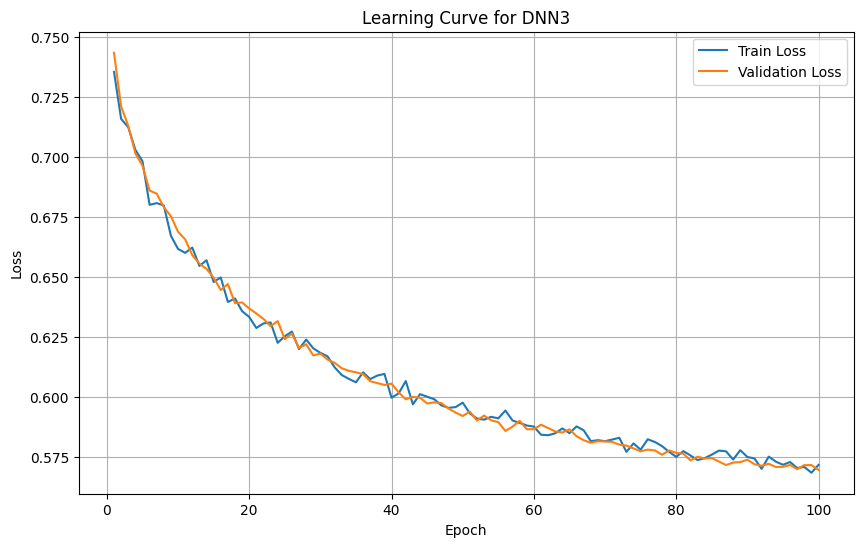

In [86]:
best_params=study.best_params
model = DNN_3(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              ).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN3')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.77%
Precision: 0.4809
Recall: 0.8525
F1 Score: 0.6149
Matthews Correlation Coefficient: 0.2867
Specificity: 0.4212


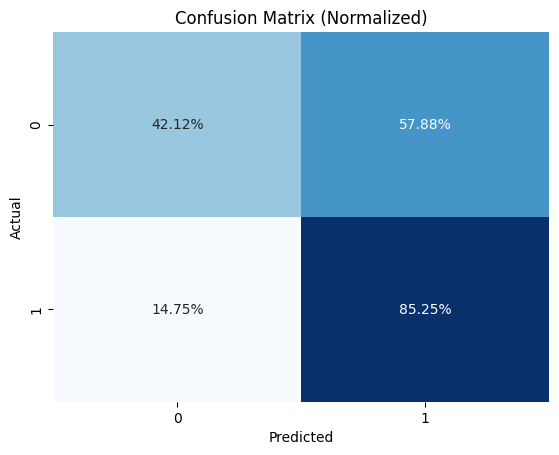

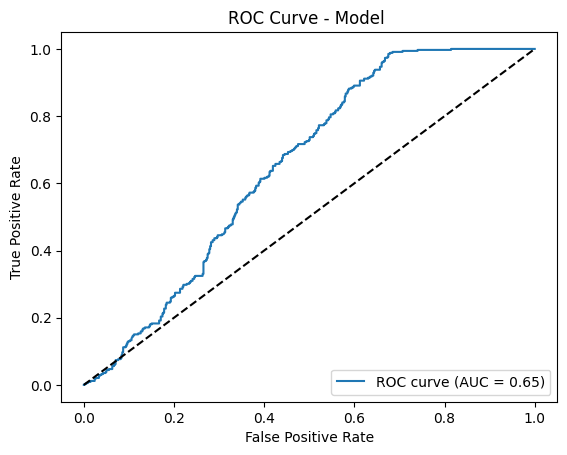

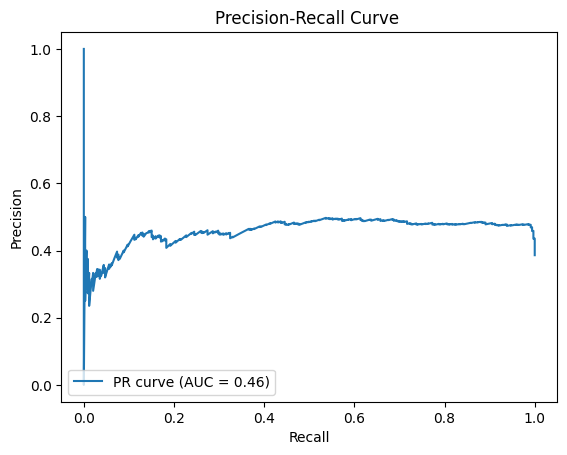

In [87]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [82]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_3.pth')



In [83]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
            Linear-3                   [-1, 16]             528
       BatchNorm1d-4                   [-1, 16]              32
           Dropout-5                   [-1, 16]               0
            Linear-6                    [-1, 8]             136
       BatchNorm1d-7                    [-1, 8]              16
           Dropout-8                    [-1, 8]               0
            Linear-9                    [-1, 4]              36
      BatchNorm1d-10                    [-1, 4]               8
           Linear-11                    [-1, 1]               5
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back